In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import numpy as np
from src.utils.simparam import SimParam  # class for show-up generator

%matplotlib inline
%config InlineBackend.figure_format='retina'


In [100]:
years = [2023, 2024, 2025, 2026]
dct_data = {
    year: pd.read_excel(
        f"/home/antoine/projects/KAPpaxsim/KAPpaxsim/data/raw/FY{year} KIX schedule forecast.xlsx",
        sheet_name="ALLdata",
        header=1,
    )
    for year in years
}
dct_data_processed = {}
dct_simparam = {}

# table should be formatted with following columns
# | A/D | T1/T2(MM/9C/7C/TW) | Intl Regions | Category(P/C/O) | Sector |
# | Flight Number | SEATS FC | PAX_SUM FC | Flight Date | Scheduled Time |

for key, data in dct_data.items():
    data["T1/T2(MM/9C/7C/TW)"] = data["Terminal"].replace(
        {"N": "T1", "S": "T1", 1: "T1", "L": "T2", np.nan: "-"}
    )

    data["Category(P/C/O)"] = data["Flight Type"].apply(lambda x: x[0])

    dct_name_change = {
        "Int / Dom": "Sector",
        "Int P Region": "Intl Regions",
        "Fight Number": "Flight Number",  # <- to be split with space between letters and digits
        "Seats": "SEATS FC",
        "PAX": "PAX_SUM FC",
        "Date": "Flight Date",
        "Time": "Scheduled Time",
    }

    dct_data_processed[key] = data.rename(columns=dct_name_change)


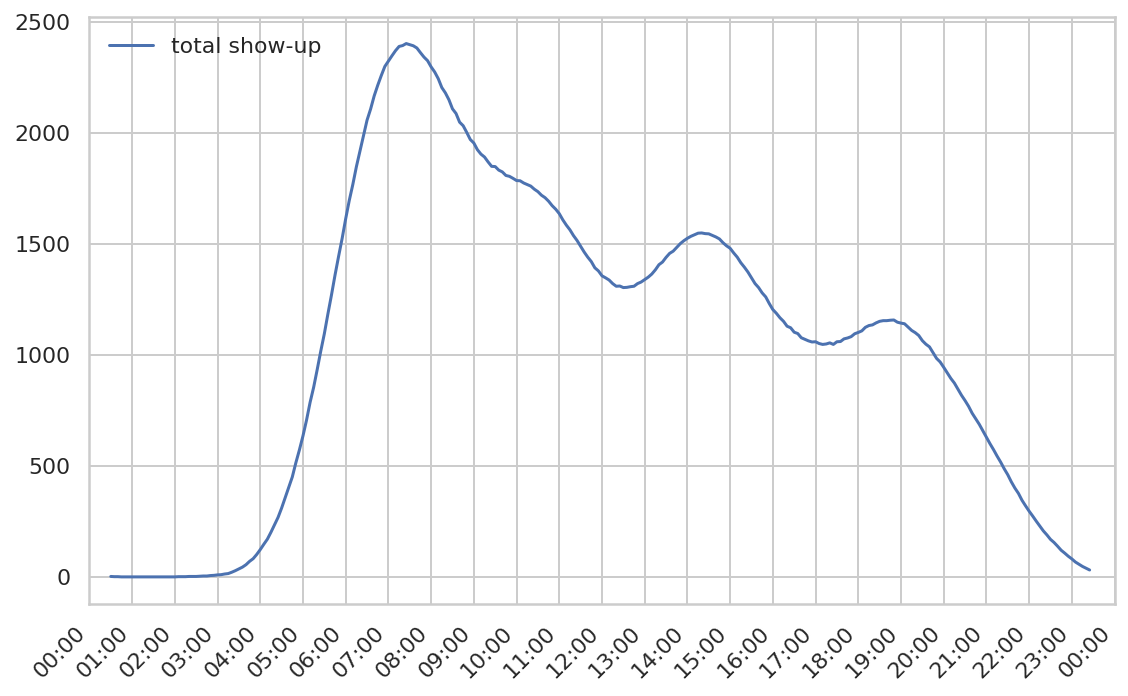

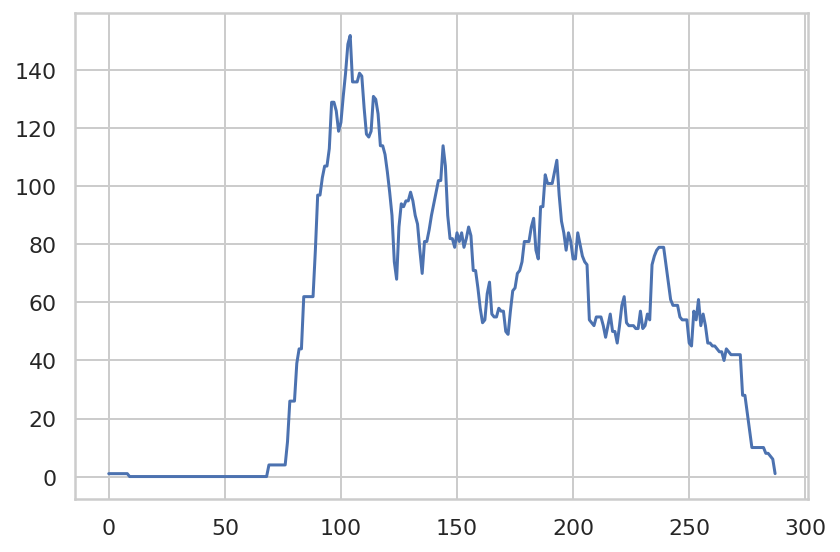

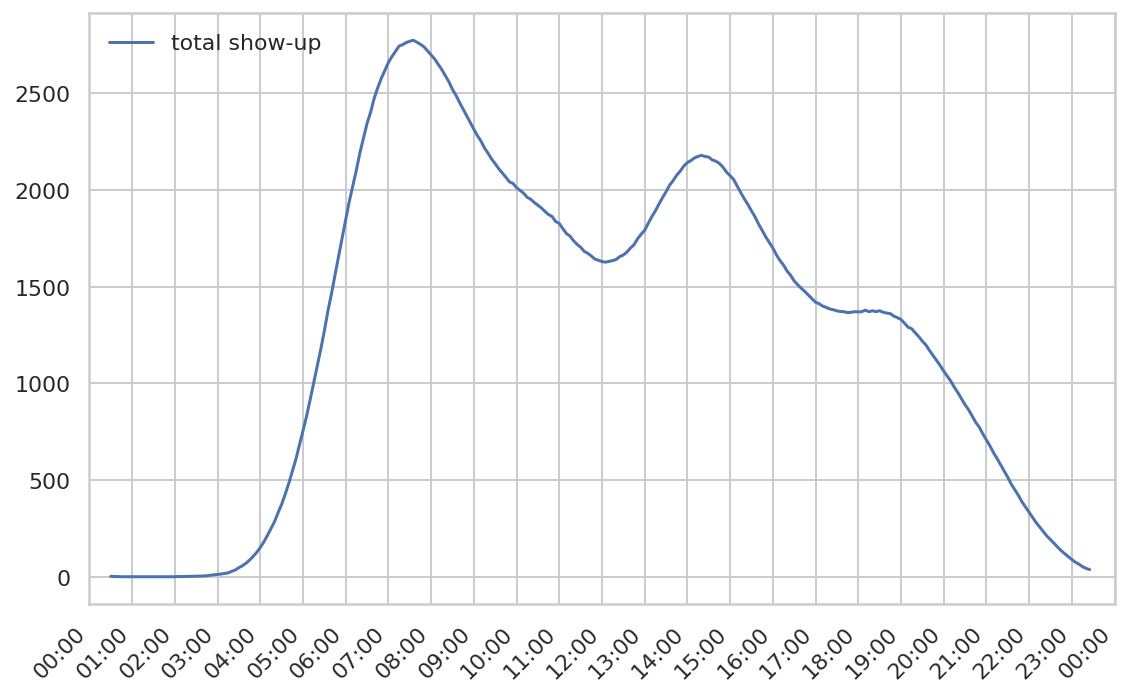

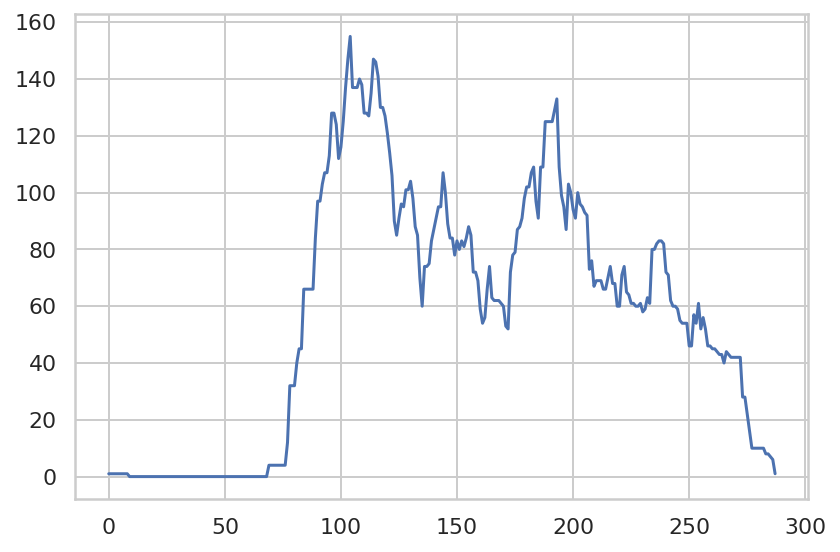

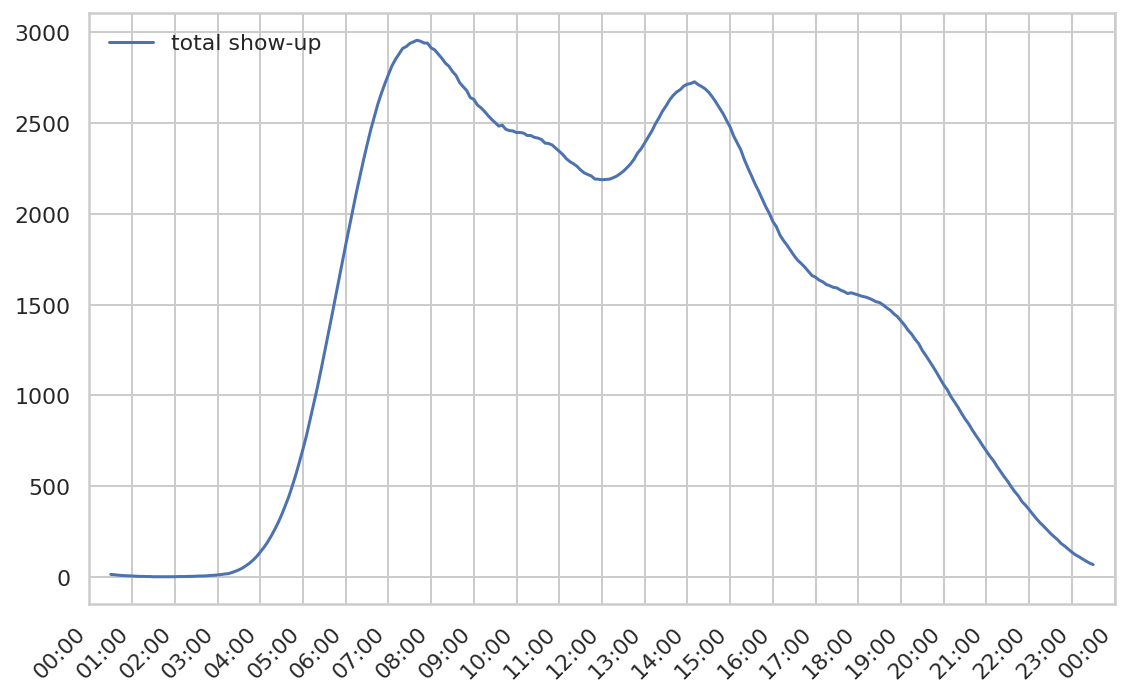

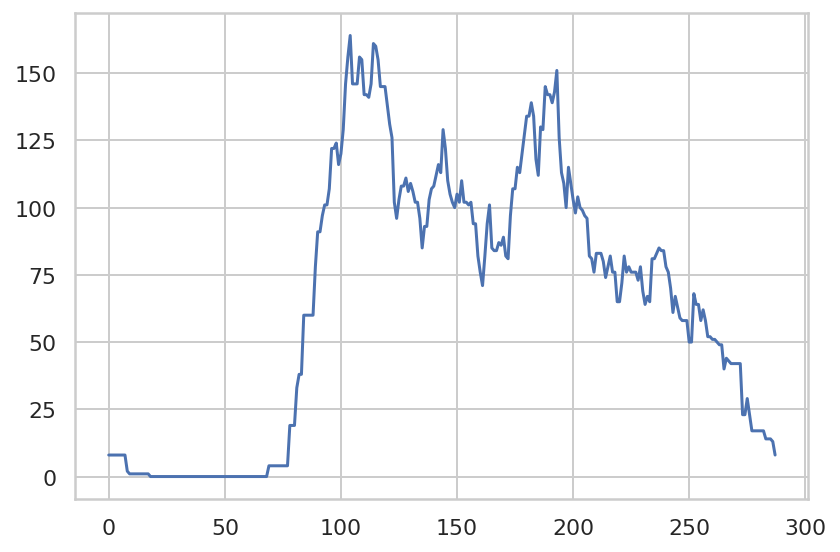

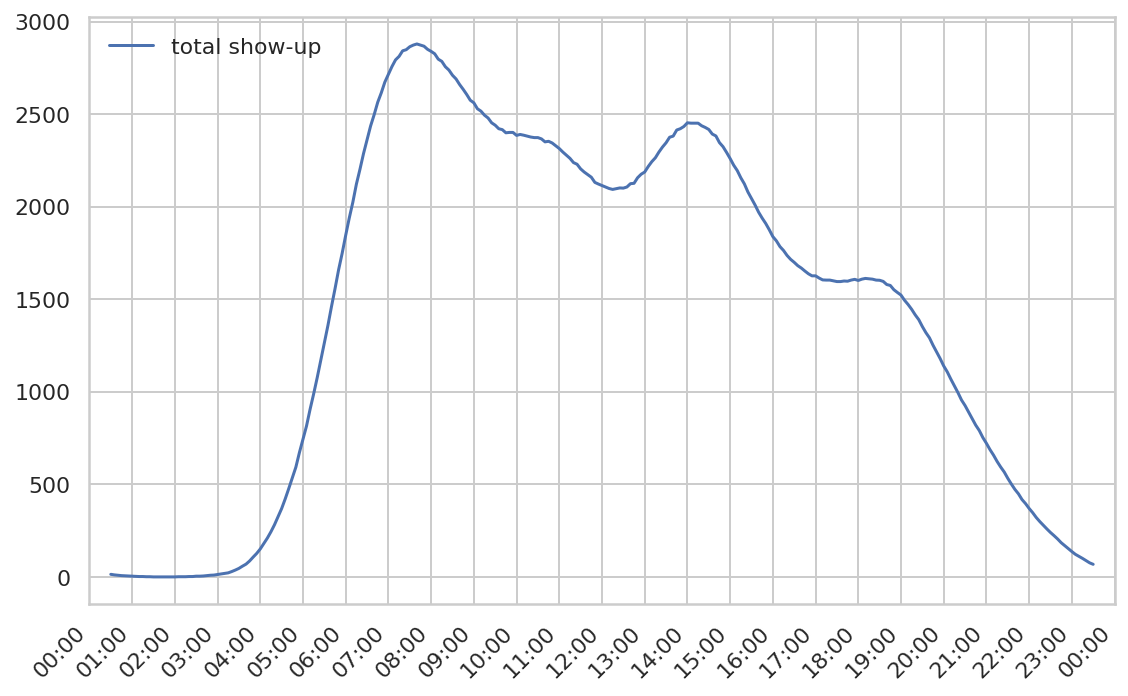

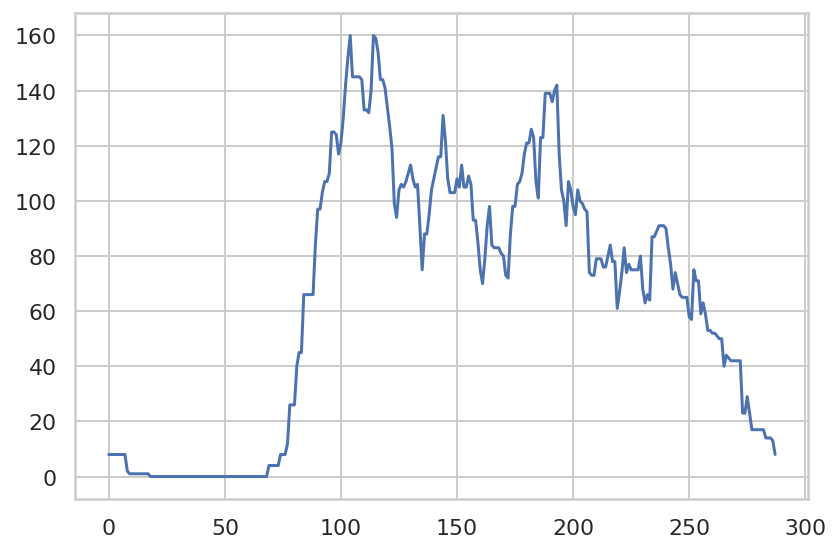

In [103]:
# really, we need to select busiest day of each year
# and let's plot on a single graph
for key, data_processed in dct_data_processed.items():
    dct_simparam[key] = SimParam()
    dct_simparam[key].schedule_from_df(data_processed)
    dct_simparam[key].schedule_cleanup()
    dct_simparam[key].schedule
    dct_simparam[key].schedule_filter(date_str=f"{key}-12-20")
    dct_simparam[key].show_up_from_file()
    dct_simparam[key].assign_flight_show_up_category_default()
    # dct_simparam.plot_show_up_categories_profiles()
    # dct_simparam.schedule['PAX_SUM FC'] = 10
    dct_simparam[key].assign_show_up()
    dct_simparam[key].plot_df_Pax()
    dct_simparam[key].assign_check_in()
    dct_simparam[key].df_Counters["total"].plot()


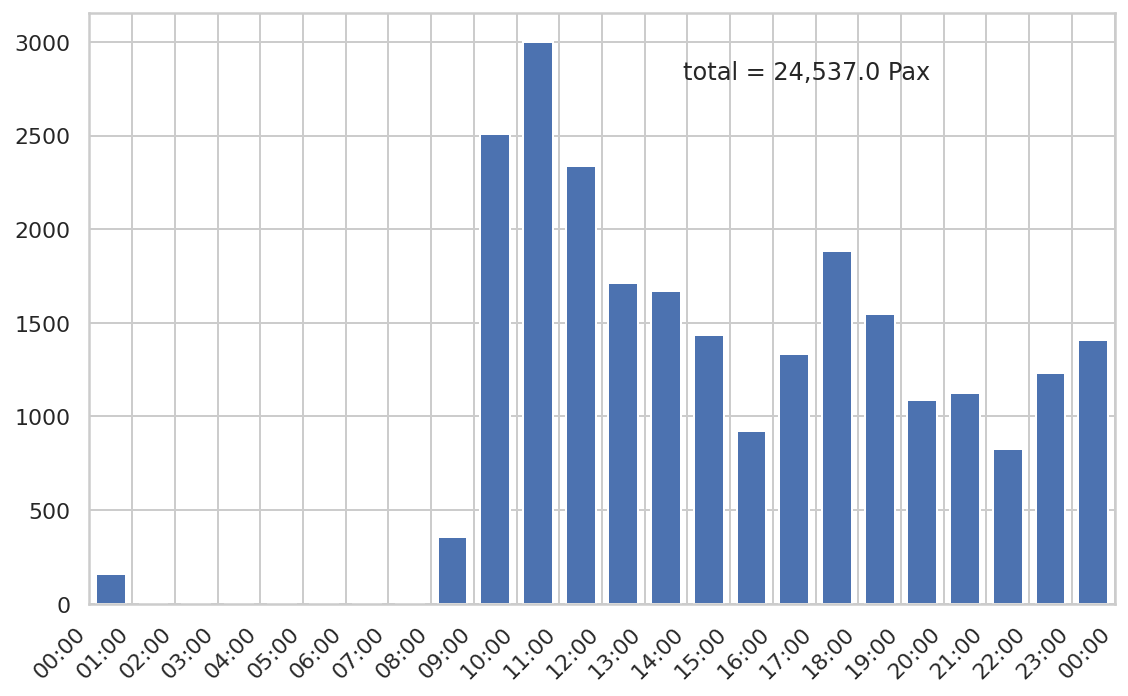

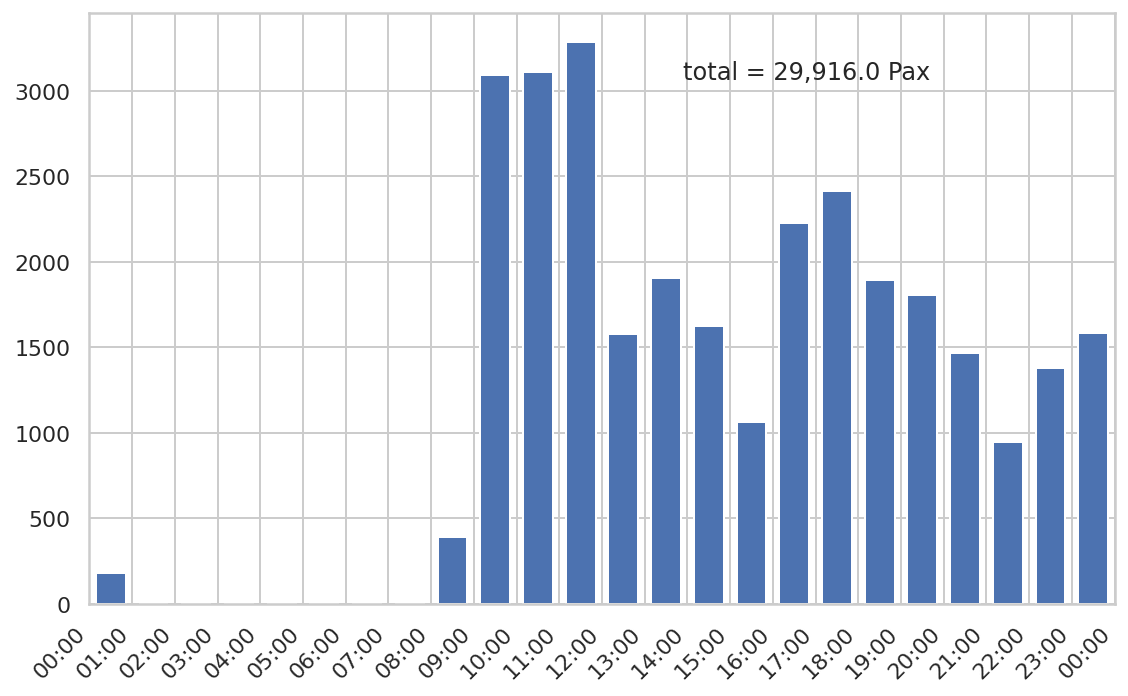

In [107]:
dct_plot_std = {}
for year in [2023, 2024]:
    dct_plot_std[year] = dct_simparam[year].plot_std()


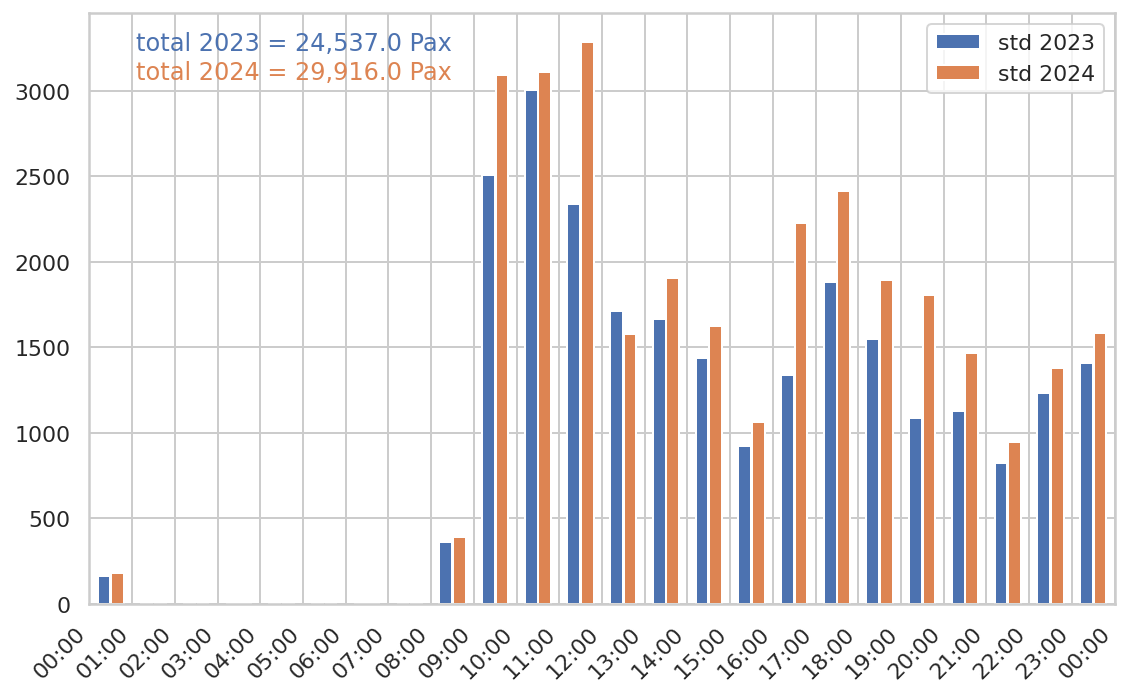

In [126]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

freq = "1H"
win = 1

sns.set_theme(style="whitegrid")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

ratio_sampling = pd.to_timedelta("1H") / pd.to_timedelta(freq)

# plot param
xmin = pd.to_datetime("2020-10-13 00:00:00")
xmax = pd.to_datetime("2020-10-14 00:00:00")
hours = mdates.HourLocator(interval=1)
half_hours = mdates.MinuteLocator(byminute=[0, 30], interval=1)
h_fmt = mdates.DateFormatter("%H:%M")
width = 0.3 * (xmax - xmin) / 24
offset = pd.Timedelta("30min")

# formatting
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_xlim((xmin, xmax))
ax.set_xticks(pd.date_range(xmin, xmax, freq="30min"))
ax.set_xticklabels(ax.get_xticks(), rotation=45, **{"horizontalalignment": "right"})
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
ax.xaxis.set_minor_locator(half_hours)

# plot
ax.bar(
    x=dct_plot_std[2023].index - width / 1.9 + offset,
    height=dct_plot_std[2023]["sum"],
    width=width,
    align="center",
    label="std 2023",
    color=colors[0],
)
ax.text(
    0.2,
    0.95,
    "total 2023 = {:,} Pax".format(dct_plot_std[2023]["sum"].sum()),
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    color=colors[0],
)

ax.bar(
    x=dct_plot_std[2024].index + width / 1.9 + offset,
    height=dct_plot_std[2024]["sum"],
    width=width,
    align="center",
    label="std 2024",
    color=colors[1],
)
ax.text(
    0.2,
    0.90,
    "total 2024 = {:,} Pax".format(dct_plot_std[2024]["sum"].sum()),
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    color=colors[1],
)

plt.legend()
plt.show()


In [122]:
# finish presentation
# do graph for a lower traffic forecast (search old stuff)